# SI docking figures

## Table of Contents
- [TOC](#table-of-contents)
- [overhead cost figures](#overhead-cost-figures)
- [false hit pruning figures](#false-hit-pruning)

In [27]:
from pathlib import Path
import sys
from typing import List

from matplotlib import pyplot as plt
import numpy as np
import seaborn as sns

sys.path.append("../")
sys.path.append("../scripts/")
from scripts.experiment import Experiment

sns.set_theme("talk", "white")

%matplotlib inline

def retained_idxss(expt) -> List[np.ndarray]:
    return [np.load(chkpt / "retained_idxs.npy") for chkpt in expt.chkpts[:-1]]

## Overhead cost figures

[back to top](#table-of-contents)

In [28]:
def gcp_dollars(cpus: float = 0., gpus: float = 0) -> float:
    return cpus * 0.0475/60**2 + gpus * 2.48/60**2
    
def cost(expt: Experiment, size: int, prune: bool = True) -> np.ndarray:
    n_tr = np.array(expt.num_acquired)
    c_tr = 6.16 * n_tr / 400e3

    if prune:
        s = [size]
        for I in retained_idxss(expt):
            s.append(len(I))
        n_pred = np.array(s)
        c_pred = 20.52 * n_pred / 98.2e6
    else:
        c_pred = 20.52 * (np.ones(expt.num_iters))

    return c_pred + c_tr

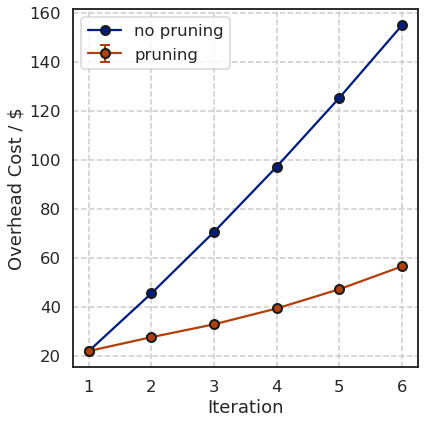

In [25]:
sns.set_palette("dark")
fig, ax = plt.subplots(1, 1, figsize=(6, 6))

size = 98.2e6
split = "0.001"

p = Path.home() / "active-projects/molpal-pruning/runs/ampc/full" / split / "rep-0"
c_full = cost(Experiment(p), size, False)

x = np.arange(len(c_full)) + 1
ax.plot(x, np.cumsum(c_full), 'o-', mec='k', mew=2, label="no pruning")

d_ampc_prune = Path.home() / "active-projects/molpal-pruning/runs/ampc/prune"
prune_costs = []
for p_exp in (d_ampc_prune / split).iterdir():
    e = Experiment(p_exp)
    prune_costs.append(np.cumsum(cost(e, size, True)))
C_prune = np.array(prune_costs)

ax.errorbar(
    x, C_prune.mean(0), yerr=C_prune.std(0), fmt='o-', mec='k', mew=2, capsize=5, label="pruning"
)
ax.set_xlabel("Iteration")
ax.set_ylabel("Overhead Cost / $")
ax.grid(True, ls="--")
ax.legend()

fig.tight_layout()

In [26]:
fig.savefig("../figures/ampc-001-cost.pdf")

## False hit pruning

[back to top](#table-of-contents)

In [6]:
def get_scores(true_csv, score_col: int = 1, title_line: bool = True) -> np.ndarray:
    with open(true_csv) as fid:
        reader = csv.reader(fid)
        if title_line:
            next(reader)

        return np.array([row[score_col] for row in tqdm(reader, leave=False)], float)

k = 50000
Y = np.load("ampc_scores.npy")

threshold = np.partition(Y[~np.isnan(Y)], k)[k]
hits = Y <= threshold
hit_idxs = np.arange(len(Y))[hits]

# scores = []
# sizes = []
# for run in (hts_runs_dir / "prob-0.01/0.004/mpn/ucb").iterdir():
#     e = Experiment(run, hts_smi_idx)
#     scores.append(
#         [e.calculate_reward(i, hts_top_N, True)[2] for i in range(e.num_iters)]
#     )
#     sizes.append(e.num_acquired)
# S = np.array(scores)
# X = np.array(sizes)

# def get_final_retained_idxs(e: Experiment):
#     retained_idxss = []
#     for chkpt_dir in e.chkpt_dirs:
#         idxs_filepath = chkpt_dir / "retained_idxs.npy"
#         if idxs_filepath.exists():
#             retained_idxss.append(np.load(idxs_filepath))

#     retained = retained_idxss[-1]
#     # for i in range(len(retained_idxss)-2, -1, -1):
#     for i in range(len(retained_idxss))[-2::-1]:
#         retained = retained_idxss[i][retained]
    
#     return retained

In [8]:
p_exp = Path.home() / "active-projects/molpal-pruning/runs/ampc/prune/0.004/12631994-2"
e = Experiment(p_exp)

In [29]:
remaining_idxs = np.arange(len(Y))
for I in retained_idxss(e):
    remaining_idxs = remaining_idxs[I]
    print((k - len(set(hit_idxs) - set(remaining_idxs))) / k)

0.8427
0.76954
0.73968
0.7169
0.7086


In [27]:
(k - len(set(hit_idxs) - set(remaining_idxs))) / k

0.8427

In [14]:
k = 50000
with open("../data/AmpC_glide_scores_top200k.csv") as fid:
    reader = csv.reader(fid)
    next(reader)

    smis_scores = [(row[0], -float(row[1])) for row in reader]
ampc_top_k = smis_scores[:k]

In [20]:
e.calculate_reward(5, ampc_top_k)

(0.9901501725985112, 0.7233, 0.7233)